# Testing to see if post hoc muscle signal extraction works

In [1]:
# get packages 
import os
import sys
import glob
import h5py

import numpy as np
import figurefirst as fifi
import matplotlib.pyplot as plt

# need to do a little work to get 'flylib' (probably a smarter way to do this)
# NB: this assumes that our current nb is in a folder that's adjacent to the flylib dir
module_path = os.path.abspath(os.path.join('..'))
flylib_path = os.path.join(module_path,"flylib")
sys.path.insert(0,flylib_path)
from flylib import flylib
from flylib.util import idx_by_thresh

In [2]:
# specify which fly we want to look at
fly_num = 18 
my_rootpath = '/media/sam/SamData/FlyDB'
side = 'left'  # just pick one side for now

# fl = flylib.NetFly(fly_num,rootpath=my_rootpath)
# fl.open_signals(extensions=['hdf5', 'cpkl'])

In [3]:
# unfortunately my file structure doesn't really match thad's, so load some things separately

# path to "converted_" + blah blah blah hdf5 file
datapath = os.path.join(my_rootpath, 'Fly%04d'%(fly_num))
conv_fn = glob.glob(os.path.join(datapath, 'converted*.hdf5'))[0]

# try reading out data
with h5py.File(os.path.join(datapath, conv_fn), 'r') as f:
    print(f.keys())
    
    # read Kinefly data
    left_amp = f['flystate_langles'][:]
    right_amp = f['flystate_rangles'][:]
    kf_time = f['flystate_tstamps'][:]
    
    # read DAQ messages (we'll get stuff from this soon)
    daq_channels = f['daq_channels'][:]
    daq_vals = f['daq_value'][:]
    daq_time = f['daq_time'][:]
    daq_tstamps = f['daq_ros_tstamps'][:]
    
    # try to read condition messages 
    test = f['exp_state']['msgs'][:]

[u'daq_channels', u'daq_ros_tstamps', u'daq_time', u'daq_value', u'exp_block', u'exp_state', u'flystate_langles', u'flystate_lgrandients', u'flystate_lintensity', u'flystate_rangles', u'flystate_rgradients', u'flystate_rintensity', u'flystate_seq', u'flystate_tstamps', u'ledpanels_panels_arg1', u'ledpanels_panels_arg2', u'ledpanels_panels_arg3', u'ledpanels_panels_arg4', u'ledpanels_panels_arg5', u'ledpanels_panels_arg6', u'ledpanels_panels_command', u'ledpanels_ros_tstamps', u'live_viewer_left', u'live_viewer_right']


### Look at reference frames -- do saved version and GUI versions differ?

In [4]:
# COMPARE MY SAVED REFFRAME AND THE ONE GENERATED BY THE GUI
my_rframe_path = os.path.join(datapath, 'live_viewer_%s_rframe_fits.hdf5'%(side))
thad_rframe_path = os.path.join(datapath, 'ca_camera_%s_rframe_fits.cpkl'%(side))

# load mine
my_rframe = dict()
with h5py.File(my_rframe_path, 'r') as f:
    my_rframe['p'] = np.unique(f['LogRefFrame/p'][:])
    my_rframe['a1'] = np.unique(f['LogRefFrame/a1'][:])
    my_rframe['a2'] = np.unique(f['LogRefFrame/a2'][:])
    my_rframe['A'] = np.unique(f['LogRefFrame/A'][:])  # .reshape((2,2))
    my_rframe['A_inv'] = np.unique(f['LogRefFrame/Ainv'][:])  # .reshape((2,2))
    
my_mview_frame = dict()
with h5py.File(my_rframe_path, 'r') as f:
    my_mview_frame['p'] = np.unique(f['ModelViewFrame/p'][:])
    my_mview_frame['a1'] = np.unique(f['ModelViewFrame/a1'][:])
    my_mview_frame['a2'] = np.unique(f['ModelViewFrame/a2'][:])
    my_mview_frame['A'] = np.unique(f['ModelViewFrame/A'][:])  # .reshape((2,2))
    my_mview_frame['A_inv'] = np.unique(f['ModelViewFrame/Ainv'][:])  # .reshape((2,2))
    
# load Thad's
import cPickle
with open(thad_rframe_path,'rb') as f:
    thad_rframe = cPickle.load(f)

pts_list = ['p', 'a1', 'a2']
for pt in pts_list:
    print('LogRefFrame: ' + str(my_rframe[pt]))
    print('ModelViewFrame: ' + str(my_mview_frame[pt]))
    print('Thad: ' + str(thad_rframe[pt]))
    print('')

LogRefFrame: []
ModelViewFrame: []
Thad: [135.77007997 237.0979384 ]

LogRefFrame: []
ModelViewFrame: []
Thad: [97.33692581  0.5682452 ]

LogRefFrame: []
ModelViewFrame: []
Thad: [ -20.70506337 -171.87611427]



In [ ]:
# load an image so we can look at things
img_path_full = glob.glob(os.path.join(datapath, 'ca_camera_%s*.hdf5'%(side)))[0]
# right_path_full = os.path.join(datapath, 'ca_camera_right.hdf5')

with h5py.File(img_path_full, 'r') as f:
    im0 = f['cam_imgs'][0]
    

In [ ]:
def get_frame_plot_pts(p, a1, a2):
    """
    quick helper function to get the points e1 and e2 from p, a1, and a2
    
    frame['a2'] = e1[1]-e2[0]
    frame['a1'] = e2[1]-e2[0]
    frame['p'] = e2[0]
    """
    e10 = p
    e11 = a2 + p
    e20 = p 
    e21 = a1 + p
    
    e1 = np.vstack((e10, e11))
    e2 = np.vstack((e20, e21))
    
    return (e1, e2)

In [ ]:
# show different registration points
fig, ax = plt.subplots()

# first get muscle frame into basis vectors
e1_thad, e2_thad = get_frame_plot_pts(thad_rframe['p'], thad_rframe['a1'], thad_rframe['a2'])
e1_logref, e2_logref = get_frame_plot_pts(my_rframe['p'], my_rframe['a1'], my_rframe['a2'])
e1_modview, e2_modview = get_frame_plot_pts(tmy_mview_frame['p'], my_mview_frame['a1'], my_mview_frame['a2'])

ax.imshow(im0,cmap="Greys_r")
ax.plot(e1_thad[:,0],  e1_thad[:,1], 'bo')
ax.plot(e2_thad[:,0],  e2_thad[:,1], 'bo')

ax.plot(e1_logref[:,0],  e1_logref[:,1], 'ro')
ax.plot(e2_logref[:,0],  e2_logref[:,1], 'ro')

ax.plot(e1_modview[:,0],  e1_modview[:,1], 'ro')
ax.plot(e2_modview[:,0],  e2_modview[:,1], 'ro')

In [21]:
# so without any editing, the one from the GUI is different from the one I saved in the expt script
#  --> is this just because of the image rotation? 
import cv2 

#   dst_p0 = dst_f['a1'] + dst_f['p']
#   dst_p1 = dst_f['p']
#   dst_p2 = dst_f['a2'] + dst_f['p']
my_pts = np.array([my_rframe['p'] + np.flip(my_rframe['a1']), 
                   my_rframe['p'], 
                   my_rframe['p']  + np.flip(my_rframe['a2'])],dtype=np.float32)
thad_pts = np.array([thad_rframe['p'] + thad_rframe['a1'],
                     thad_rframe['p'],
                     thad_rframe['p']  + thad_rframe['a2']],dtype=np.float32)

print(my_pts)
print(thad_pts)

# A = cv2.getAffineTransform(my_pts, thad_pts)
# print(A)

# test = my_rframe['A_inv']*thad_rframe['A']
# print(test)

[[244.3894  213.14607]
 [135.80914 193.46039]
 [172.09764  33.17257]]
[[229.90363 217.58028]
 [133.60152 195.9278 ]
 [164.61763  30.34641]]


(270, 360)


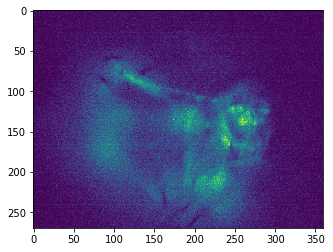

In [24]:
# cv2.imshow("test",im0_left)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Compare camera time stamps 

In [25]:
# read in time stamps from left and right ca cameras, as well as kine camera
left_path_full = os.path.join(datapath, 'ca_camera_left.hdf5')
right_path_full = os.path.join(datapath, 'ca_camera_right.hdf5')
kine_path_full = os.path.join(datapath, 'kine_camera_1.hdf5')

with h5py.File(left_path_full, 'r') as f:
    ros_tstamps_left = f['cam_ros_tstamps'][:]
    tstamps_left = f['cam_tstamps'][:]
    
with h5py.File(right_path_full, 'r') as f:
    ros_tstamps_right = f['cam_ros_tstamps'][:]
    tstamps_right = f['cam_tstamps'][:]

        
with h5py.File(kine_path_full, 'r') as f:
    ros_tstamps_kine = f['cam_ros_tstamps'][:]
    tstamps_kine = f['cam_tstamps'][:]

In [26]:
print(ros_tstamps_left[:20] - ros_tstamps_kine[:20])
print(tstamps_left[:20] - tstamps_kine[:20])

print(ros_tstamps_kine.shape)
print(ros_tstamps_left.shape)

[-0.0229156  -0.04482698 -0.06827021 -0.09163785 -0.11487651 -0.13837695
 -0.15113831 -0.17607546 -0.19800115 -0.2206409  -0.24424982 -0.26744676
 -0.29121113 -0.31445479 -0.33792329 -0.36077046 -0.38380146 -0.4068718
 -0.42999721 -0.44274688]
[-0.02088571 -0.0437696  -0.06697273 -0.09017825 -0.1135416  -0.13674808
 -0.14982939 -0.17329693 -0.1964395  -0.21961975 -0.2428112  -0.2661016
 -0.28925586 -0.31255674 -0.33584213 -0.35889816 -0.38225436 -0.40548444
 -0.42860794 -0.44154382]
(13710,)
(43065,)


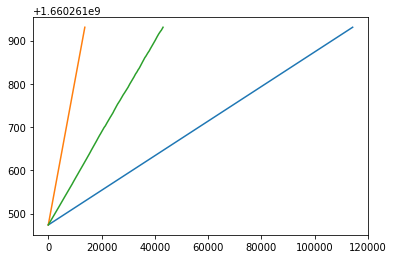

In [28]:
daq_t_diff = daq_time - daq_tstamps
plt.plot(daq_tstamps)
# plt.plot(daq_time)
plt.plot(kf_time)
plt.plot(ros_tstamps_left)
# plt.plot(tstamps_left)

### Reading DAQ messages

In [12]:
# get info from DAQ messages
freq_idx = np.where(daq_channels == 'freq')
wb_freq = daq_vals[freq_idx[0],freq_idx[1]]

x_pos_idx = np.where(daq_channels == 'xpos')
x_pos = daq_vals[x_pos_idx[0],x_pos_idx[1]]

y_pos_idx = np.where(daq_channels == 'ypos')
y_pos = daq_vals[y_pos_idx[0],y_pos_idx[1]]

In [13]:
freq_idx = np.where(daq_channels[:10]=='freq')
print(daq_channels[:10])
print(daq_vals[:10])
print(daq_vals[freq_idx[0],freq_idx[1]])

[['clock' 'lmr' 'freq' 'lpr' 'chrimson' 'xpos' 'ypos']
 ['clock' 'lmr' 'freq' 'lpr' 'chrimson' 'xpos' 'ypos']
 ['clock' 'lmr' 'freq' 'lpr' 'chrimson' 'xpos' 'ypos']
 ['clock' 'lmr' 'freq' 'lpr' 'chrimson' 'xpos' 'ypos']
 ['clock' 'lmr' 'freq' 'lpr' 'chrimson' 'xpos' 'ypos']
 ['clock' 'lmr' 'freq' 'lpr' 'chrimson' 'xpos' 'ypos']
 ['clock' 'lmr' 'freq' 'lpr' 'chrimson' 'xpos' 'ypos']
 ['clock' 'lmr' 'freq' 'lpr' 'chrimson' 'xpos' 'ypos']
 ['clock' 'lmr' 'freq' 'lpr' 'chrimson' 'xpos' 'ypos']
 ['clock' 'lmr' 'freq' 'lpr' 'chrimson' 'xpos' 'ypos']]
[[ 0.00000000e+00  0.00000000e+00  1.83500000e+02  2.54000000e+02
  -1.47058824e-01  2.86764706e+00  9.77941176e+00]
 [ 0.00000000e+00  0.00000000e+00  1.83500000e+02  2.51500000e+02
  -1.47058824e-01  2.86764706e+00  9.77941176e+00]
 [ 0.00000000e+00  0.00000000e+00  1.83500000e+02  2.45500000e+02
  -1.47058824e-01  2.86764706e+00  9.77941176e+00]
 [ 0.00000000e+00  0.00000000e+00  1.83500000e+02  2.52000000e+02
  -1.47058824e-01  2.86764706e+0

In [14]:
print(y_pos.shape)

(114221,)


### Try to back out time interval to resample over

In [15]:
# quick test to see what array size Thad's code spits out
tmp_path = '/media/sam/SamData/FlyDB/tmp_Fly0002/backup'
tmp_fn = 'left_amp.hdf5'

with h5py.File(os.path.join(tmp_path, tmp_fn), 'r') as f:
    tmp = f['left_amp'][:]

print(tmp.shape)

(22800, 1)


In [16]:
tmp_dt = np.floor(tstamps_left[-1] - tstamps_kine[0])
print(50*tmp_dt)

22800.0


In [17]:
# okay, so for next time:
#   - i think i can just use a pipeline where I use nearest-neighbor interpolation to get resampled-values
#   - based on the above, I can get out Thad's array size
#   - just need to make sure everything is aligned to a common time; however, Thad's unbag code seems to assume this

### Trying to figure out muscle model stuff

In [18]:
# import muscle_model module
module_path = os.path.abspath(os.path.join('..'))
model_path = os.path.join(module_path,"planotaxis","models")
sys.path.insert(0, os.path.join(model_path, "muscle_model"))
print(os.path.join(model_path, "muscle_model"))

import muscle_model as mm
import cPickle

# also define model name
model_name = 'thorax'

/home/sam/Documents/code/muscle_imaging/planotaxis/models/muscle_model


In [19]:
# going to use muscle_model.GeometricModel, but want to see if it matters whether I:
#    1) call it using just a filepath
#    2) call it using 'lines' and 'frame'

# general path to outlines.cpkl file
outline_path_full = os.path.join(model_path, model_name, 'outlines.cpkl')

# option 1:
model_out1 = mm.GeometricModel(filepath=outline_path_full)

# option 2:
with open(outline_path_full, 'rb') as pklf:
    outlines = cPickle.load(pklf)
    
e1 = outlines['e1']
e2 = outlines['e2']

muscle_dict = dict()
for key in outlines.keys():
    if not (key in ['e1', 'e2']):
        muscle_dict[key] = outlines[key]
frame = mm.Frame()
frame['a2'] = e1[1] - e2[0]
frame['a1'] = e2[1] - e2[0]
frame['p'] = e2[0]
model_out2 = mm.GeometricModel(muscle_dict, frame)

# *** they're the same!!

In [20]:
# also check that loading pickle file for frame retains status as Frame object
thad_rframe_path = os.path.join(datapath, 'ca_camera_left_rframe_fits.cpkl')

with open(thad_rframe_path,'rb') as f:
    thad_rframe = cPickle.load(f)

In [21]:
# -> looks like I just need to construct it myself
test = mm.Frame()
test['a1'] = thad_rframe['a1']
test['a2'] = thad_rframe['a2']
test['p'] = thad_rframe['p']

In [22]:
# now need to figure out how to get muscle list...
mm.get_muscle_list('GMR39E01')

['b1', 'b2', 'b3', 'hg1', 'hg2', 'hg3', 'hg4', 'iii1', 'iii3', 'nm', 'pr']

In [24]:
tmp_path = '/home/sam/Documents/code/muscle_imaging/planotaxis/models/thorax/profiles'
tmp_fn = 'GMR39E01.cpkl'

with open(os.path.join(tmp_path, tmp_fn),'rb') as f:
    profile_maybe = cPickle.load(f)
    
print(profile_maybe['selected_components'])

['b1', 'b2', 'b3', 'pr', 'nm', 'iii24', 'i1', 'iii1', 'iii3', 'hg2', 'hg3', 'hg1', 'hg4']


In [2]:
VARIABLES_DICT = {'left_amp' : ('%s_blah', 'flystate_langles')
                  }

In [5]:
signals_path = os.path.join('/media/sam/SamData/FlyDB/Fly0002', 'ca_camera_left_model_fits.hdf5')
with h5py.File(signals_path, 'r') as h5f:
    print(h5f.keys())

[u'b1', u'b2', u'b3', u'bkg', u'hg1', u'hg2', u'hg3', u'hg4', u'i1', u'iii1', u'iii24', u'iii3', u'nm', u'pr', u't']


In [14]:
test = {'blah': 5, 'bleh': 6}
key_list = ['blah','bleh']
print(all([(k in test.keys()) for k in key_list]))

True
